# Preliminary Exploration: American Express Kaggle Challenge 
I worked on Colab, with 12gb of RAM I had to sample 1/10th of the 5mln records training set


## Preprocessing

Lots of memory limitations due to the size of the dataset, it required a little bit of tinkering with many things to fit the Colab limitations

### Downloading and Unzipping the Dataset
I had come up with two different progress bar as the zipfile library didn't make any call back possible inside its functions and classes

In [1]:
from pathlib import Path
import urllib.request
from tqdm import tqdm
import zipfile
import os

# Function I wrote to download a file getting a progressbar
def download(url, file_name):

    class MyProgressBar():

        def __init__(self):
            self.pbar = None

            #requesting file size from url
            request = urllib.request.Request(url, method='HEAD')
            self.total_size = int(urllib.request.urlopen(request).headers['Content-Length'])

        def __call__(self, block_num, block_size, wrong_size):
            #if the pbar doesn't exist yet
            if not self.pbar:
                self.pbar = tqdm(ascii=True, desc=f'Downloading {file_name}',
                                 total = self.total_size, position=0, leave=True)

            #tracing the size of the downloaded blocks
            downloaded = block_num * block_size
            missing = self.total_size - downloaded
            
            #updating according to either the missing size or the entire block size
            if downloaded < self.total_size:
                self.pbar.update(block_size)
            else:
                self.pbar.update(missing)

    # Downloading data
    urllib.request.urlretrieve(url, file_name, MyProgressBar())
    return

# Function I wrote to unzip a file getting a progressbar
def unzip(path, file_name):

    # Unzipping the data
    zip_ref = zipfile.ZipFile(file_name)

    for zipped_file in zip_ref.filelist:
        # Finding a file in the zip and opening it
        zipped_name = zipped_file.filename
        origin = zip_ref.open(zipped_name)

        # Creating the path and opening the file to write
        Path(path).mkdir(exist_ok=True)
        destination = open(f"{path}/{zipped_name}", 'wb')
        
        #defining the block size to unzip at each iteration
        block_size = 8192
        #getting the file to unzip size
        file_size = zipped_file.file_size

        #computing the total size to unzip (according to the blocks unzipped each time)
        max_size = ( 1 + (file_size // block_size) ) * block_size + 1

        #setting a progress bar
        pbar = tqdm(ascii=True, desc=f'Unzipping {zipped_name}',
                    total= max_size, position=0, leave=True)
        
        condition = True
        #if there is still a block to unzip continue
        while condition == True:
            block = origin.read(block_size)
            
            if not block:
                condition = False
                break
                
            destination.write(block)
            pbar.update(block_size)

        pbar.update()
        origin.close()
        destination.close()
    return

#download, unzip and remove zip file
def download_unzip(path, file_name, url):
    download(url, file_name)
    print(f'...{file_name} downloaded successfully...')
    unzip(path, file_name)
    os.remove(file_name)

In [2]:
# Loading file with the download urls
with open('drive/MyDrive/download_AMEX.txt', 'r') as f:
    labels_url, train_url = f.read().split('\n')

# Path to save into
path = 'AMEX_Dataset'

# Downloading and unzipping training data and labels
download_unzip(path, 'training_labels.zip', labels_url)
download_unzip(path, 'training_data.zip', train_url)

# Moving inside the Dataset folder
os.chdir(path)
os.getcwd()

...training_labels.zip downloaded successfully...


Unzipping train_labels.csv: 100%|##########| 30752769/30752769 [00:00<00:00, 72990079.11it/s]


...training_data.zip downloaded successfully...


Unzipping train_data.csv: 100%|##########| 16393289729/16393289729 [03:58<00:00, 68797531.72it/s]


'/content/AMEX_Dataset'

### Getting a Sample of the Dataset
I couldn't work with neither colab nor my pc otherwise

In [4]:
import pandas as pd
from random import sample
from math import ceil as roundup

# Dataset size got from a previous full loading of the dataset
dataset_size = 5531450

# Get a sample of the indexes
sampled_idx = sample([x for x in range(dataset_size)], dataset_size // 10)

# Creating a list with the indexes sorted
sorted_idxs = sorted(sampled_idx)

In [5]:
# Creating empty DataFrame
df = pd.DataFrame(columns = pd.read_csv('train_data.csv', nrows=0).columns)

# Chunking to 100.000 records per iteration
chunksize = 100000
iterations = roundup(dataset_size / chunksize)
df_iter = pd.read_csv('train_data.csv', chunksize=chunksize)

for n, df_chunk in tqdm(enumerate(df_iter), total = iterations):
    # geting only indexes which were selected with the random sample
    idxs = [x for x in sorted_idxs if x >= 100000 * n and x < 100000 * (n + 1)]
    
    df_chunk = df_chunk.loc[idxs]
    df = pd.concat((df, df_chunk))
    del df_chunk

100%|██████████| 56/56 [05:16<00:00,  5.66s/it]


### Adding original indexes to the DataFrame

In [6]:
df.insert(loc=0, column = 'original_indexes', value = sorted_idxs)

### Adding the labels to the DataFrame

In [7]:
labels = pd.read_csv('train_labels.csv')
target_col = df.merge(labels, on = 'customer_ID')['target']

# adding column to the dataframe
df.insert(loc=1, column = 'target', value = target_col.values)
df.reset_index(drop = True, inplace = True)
df.head()

,original_indexes,target,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,5,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-08-04,0.945964,0.001746,0.007863,1.005006,0.004220,0.110946,...,NaN,NaN,NaN,0.001924,0.008598,0.004529,NaN,0.000674,0.002223,0.002884
1,12,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-13,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,...,NaN,NaN,NaN,0.007186,0.004234,0.005086,NaN,0.005810,0.002970,0.008533
2,20,0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-10-20,0.916234,0.038577,0.011442,1.008145,0.006165,0.123016,...,NaN,NaN,NaN,0.009322,0.006410,0.009879,NaN,0.007611,0.001233,0.002165
3,29,0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2017-06-10,0.852514,0.006877,0.007627,0.819987,0.009290,NaN,...,NaN,NaN,NaN,0.007998,0.003724,0.005225,NaN,0.005043,0.001033,0.005859
4,31,0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2017-08-12,0.902419,0.005366,0.003352,0.811922,0.004008,NaN,...,NaN,NaN,NaN,0.000371,0.005389,0.000652,NaN,0.002085,0.008756,0.006932


### Converting Human Dates to Machine Readable Unix Dates

In [8]:
from datetime import datetime
import time

def to_unix_time(date_string, format = '%Y-%m-%d'):
    to_date = datetime.strptime(date_string, format)
    unix_time = time.mktime(to_date.timetuple())
    return unix_time

df['S_2'] = df['S_2'].apply(lambda x: to_unix_time(x))

#I will convert this column to int32 as the max value possible is 2,147,483,647
#And current date (20/11/2022) to Unix output 1,668,937,945

### Get type caster for columns
To compress the size of the excessive info in the dataset

In [9]:
import numpy as np

attributes = [col for col in df.columns if col not in {'original_indexes', 'target', 'customer_ID'}]

types = [type(x) for x in df[attributes].loc[0]]

for n in range(len(types)):
    if types[n] == np.float64:
        types[n] = np.float16
    if types[n] == np.int64:
        types[n] = np.int16

In [10]:
cast_type = {attributes[n] : t for n, t in enumerate(types)}
cast_type.update({'S_2' : np.int32, 'original_indexes': np.int32, 'target' : np.int8, 'customer_ID' : str})
list(cast_type.items())[-10:]

[('D_139', numpy.float16),
 ('D_140', numpy.float16),
 ('D_141', numpy.float16),
 ('D_142', numpy.float16),
 ('D_143', numpy.float16),
 ('D_144', numpy.float16),
 ('D_145', numpy.float16),
 ('original_indexes', numpy.int32),
 ('target', numpy.int8),
 ('customer_ID', str)]

In [11]:
df = df.astype(cast_type)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553145 entries, 0 to 553144
Columns: 192 entries, original_indexes to D_145
dtypes: float16(185), int32(2), int64(1), int8(1), object(3)
memory usage: 216.8+ MB


### Getting Categorical Variables

In [13]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical.remove('customer_ID')

#removing the types of these two columns
for col in categorical:
    del cast_type[col]

categorical

['D_63', 'D_64']

### Plotting the categorical variables

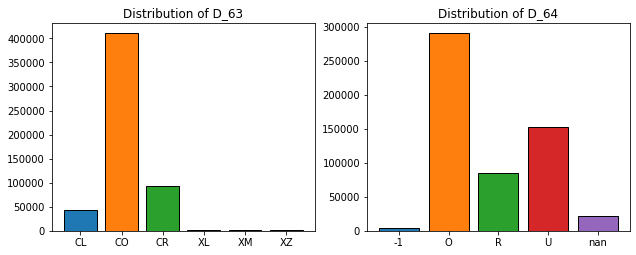

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 13)) 
fig_dims = (3, 3)

plt.subplot2grid(fig_dims, (0, 0), title=f'Distribution of {categorical[0]}')
plt.bar(*np.unique(df[categorical[0]], return_counts = True), 
        color = [f'C{n}' for n in range(len(df[categorical[0]].unique()))], edgecolor = 'k')

plt.subplot2grid(fig_dims, (0, 1), title=f'Distribution of {categorical[1]}')
plt.bar(*np.unique(df[categorical[1]], return_counts = True), 
        color = [f'C{n}' for n in range(len(df[categorical[1]].unique()))], edgecolor = 'k')

plt.show()

### One-hot encoding categorical variables

In [15]:
encoded_categoricals = pd.get_dummies(df[categorical])
#adding the types of the new columns
cast_type.update({col : np.int8 for col in encoded_categoricals})

df = pd.concat((df, encoded_categoricals), axis = 1)
df.drop(categorical, axis = 1, inplace = True)
del encoded_categoricals

In [16]:
df.head()

,original_indexes,target,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,...,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan
0,5,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,1501804800,0.945801,0.001746,0.007866,1.004883,0.004219,0.110962,...,0,1,0,0,0,0,1,0,0,0
1,12,0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,1520899200,0.934570,0.009117,0.009384,1.007812,0.006104,0.135010,...,0,1,0,0,0,0,1,0,0,0
2,20,0,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,1508457600,0.916016,0.038574,0.011444,1.007812,0.006165,0.122986,...,1,0,0,0,0,0,1,0,0,0
3,29,0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,1497052800,0.852539,0.006878,0.007626,0.819824,0.009293,NaN,...,1,0,0,0,0,0,0,1,0,0
4,31,0,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,1502496000,0.902344,0.005367,0.003351,0.812012,0.004009,NaN,...,1,0,0,0,0,0,0,1,0,0


## Filling missing values with -99

In [17]:
df = df.fillna(-99)

### Clearing all stored variables
To free up RAM

In [18]:
def cleanram_exclude(exclude = 'df'):

    import sys

    def size_b(size):
        for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
            if abs(size) < 1024:
                return f"{size:3.1f} {unit}B"
            size /= 1024
        return f"{size:.1f} YiB"
    
    for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                            key= lambda x: -x[1])[:10]:
      
        variable_size = size_b(size)
        _, unit = variable_size.split()

        if unit == 'GiB' or unit == 'MiB':
            print(f"{name:>15}: {variable_size:>8}")

            if name != exclude and name not in exclude:
                del globals()[name]

In [19]:
cleanram_exclude(exclude = 'df')

             df: 273.8 MiB
         labels: 56.5 MiB
     target_col:  8.4 MiB
    sorted_idxs:  4.7 MiB
    sampled_idx:  4.2 MiB


### Storing the DataFrame and the casting of types

In [20]:
# Saving the DataFrame
df.to_csv('../drive/MyDrive/AMEX_training_(One_Fifth_Sampled).csv', index = False)

In [21]:
import pickle

with open('../drive/MyDrive/AMEX_cast_type.pickle', 'wb') as handle:
    pickle.dump(cast_type, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
os.chdir('../')
os.remove(f'{path}/train_data.csv')
os.remove(f'{path}/train_labels.csv')
os.rmdir(f'{path}')
print('Removed all previous files and directories')

Removed all previous files and directories


## EDA

### Train-test split: Managing the RAM problem

---

It is a bit of a overkill, and I lost a lot of time here but I wanted to understand how child processes would work out in limiting my RAM usage (calling df.values costed too much RAM to execute)

In [23]:
%%file get_train_test_split.py

import os
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
from math import ceil

from sklearn.model_selection import train_test_split
import concurrent.futures

def get_cast_dataframe(path_df, path_meta):
    df = pd.read_csv(path_df)

    with open(path_meta, 'rb') as handle:
        cast_type = pickle.load(handle)

    return df.astype(cast_type)

def get_X(df, attributes, start, end):
    return df[attributes].loc[start:end].values

def process(*args):
    function = args[0]
    parameters = args[1:]
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
        result = executor.submit(function, *parameters).result()

    return result

if __name__ == '__main__':
    
    path_to_df = 'drive/MyDrive/AMEX_training_(One_Fifth_Sampled).csv'
    meta_types = 'drive/MyDrive/AMEX_cast_type.pickle'

    df = process(get_cast_dataframe, path_to_df, meta_types)
    attributes = [col for col in df.columns if col not in {'target', 'customer_ID'}]
    X_0 = df[attributes].loc[0].values

    # I needed to chunk the process as it would overexceed my RAM otherwise
    chunks = 300000
    iterations = ceil(len(df) / chunks)
    for n in tqdm(range(iterations), total = iterations):
        rows = process(get_X, df, attributes, (chunks*n)+1, chunks*(n+1))
        locals()[f'X_{n+1}'] = np.vstack((locals()[f'X_{n}'], rows))
        del locals()[f'X_{n}'], rows

    X = locals()[f'X_{n+1}']
    y = df['target']
    del df, locals()[f'X_{n+1}']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                        stratify=y, random_state=42)
    del X, y

    np.save('drive/MyDrive/X_train.npy', X_train)
    np.save('drive/MyDrive/X_test.npy', X_test)
    y_train.to_csv('drive/MyDrive/y_train.csv', index = False)
    y_test.to_csv('drive/MyDrive/y_test.csv', index = False)

    del X_train, X_test, y_train, y_test

Writing get_train_test_split.py


In [24]:
!python3 get_train_test_split.py

100% 2/2 [00:47<00:00, 23.83s/it]


### Loading the Training and Validation set
The numpy arrays stored

In [25]:
X_train, X_test = np.load('drive/MyDrive/X_train.npy', allow_pickle = True), np.load('drive/MyDrive/X_test.npy', allow_pickle = True)
y_train, y_test = pd.read_csv('drive/MyDrive/y_train.csv'), pd.read_csv('drive/MyDrive/y_test.csv')

train_index, test_index = X_train[:,0], X_test[:,0]
X_train, X_test = np.delete(X_train, 0, axis = 1), np.delete(X_test, 0, axis = 1)

### Balancing of the target variable

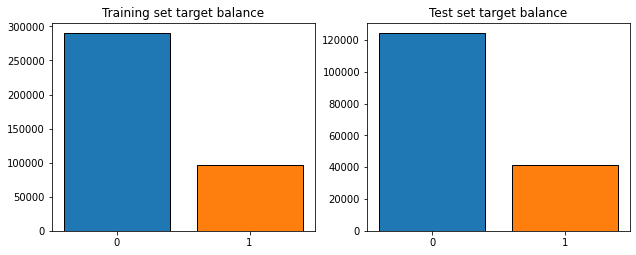

In [26]:
fig = plt.figure(figsize=(16, 13)) 
fig_dims = (3, 3)

plt.subplot2grid(fig_dims, (0, 0), title='Training set target balance')
plt.bar(*np.unique(y_train, return_counts = True), color = ['C0', 'C1'], edgecolor = 'k')
plt.xticks([0, 1])

plt.subplot2grid(fig_dims, (0, 1), title='Test set target balance')
plt.bar(*np.unique(y_test, return_counts = True), color = ['C0', 'C1'], edgecolor = 'k')
plt.xticks([0, 1])

plt.show()

### Feature Selection

In [27]:
from sklearn.feature_selection import SelectKBest

sel = SelectKBest(k=20)
X_train_SKB = sel.fit_transform(X_train, np.ravel(y_train))
X_test_SKB = sel.transform(X_test)

print('Number of Features:', X_train_SKB.shape[1])

Number of Features: 20


In [28]:
attributes = [col for col in df.columns if col not in {'original_indexes', 'target', 'customer_ID'}]

In [29]:
sel.get_support(indices=True)

array([  3,   5,  12,  15,  17,  21,  24,  25,  26,  30,  32,  43,  54,
        55,  70,  72,  74,  87, 140, 142])

In [30]:
selected_features = [attributes[n] for n in sel.get_support(indices=True)]
print(selected_features)

['B_1', 'R_1', 'B_4', 'R_2', 'D_47', 'B_7', 'D_51', 'B_9', 'R_3', 'D_53', 'B_11', 'D_58', 'B_17', 'B_18', 'B_23', 'P_4', 'D_75', 'R_10', 'R_26', 'B_38']


## Classification

### Decision Tree
Only here I performed some proper hyper-parameter tuning, I wanted to finish in a day and the other classifiers would have required sampling further to have results fast... </br> 
It is anyway possible to visualize the tree here to have an understanding of the basic inner workings of the predictions of the other models as they are not easily explainable as this one

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree

import pydotplus
from IPython.display import Image

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [32]:
dtc = DecisionTreeClassifier()

param_list = {'criterion': ['entropy', 'gini'],
             'max_depth': [None] + [2, 7],
             'min_samples_split': [2, 7, 15],
             'min_samples_leaf': [1, 7, 15]
             }

grid_search = GridSearchCV(dtc, param_grid=param_list, scoring='f1')
grid_search.fit(X_train_SKB, y_train)
print(grid_search.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=15)


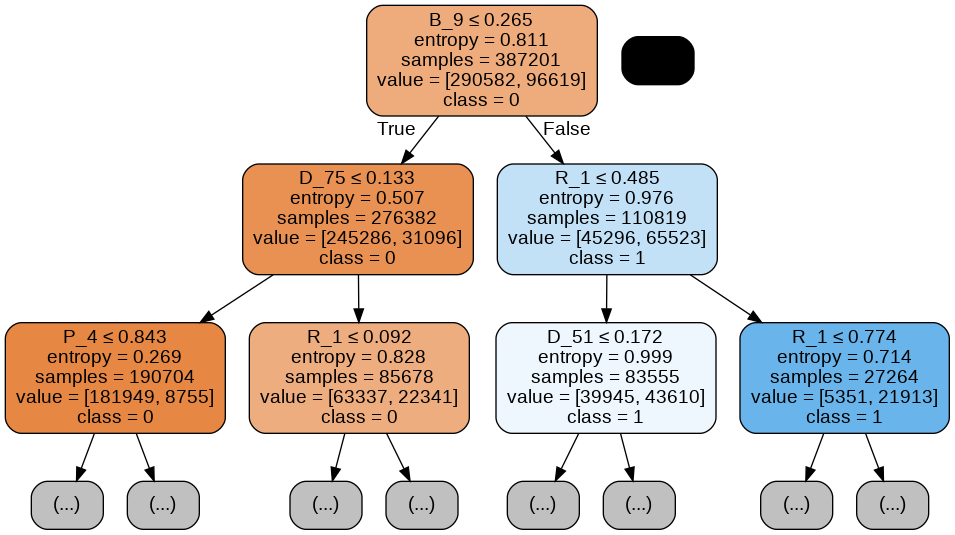

In [33]:
dtc = grid_search.best_estimator_

dot_data = tree.export_graphviz (dtc, out_file=None,
                                feature_names=selected_features,
                                class_names=[str(v) for v in dtc.classes_],
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth=2)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

ROC AUC 0.8966284891635214
Accuracy 0.8396989345803404
F1-score [0.89529268 0.65824736]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90    124536
           1       0.70      0.62      0.66     41408

    accuracy                           0.84    165944
   macro avg       0.79      0.77      0.78    165944
weighted avg       0.83      0.84      0.84    165944



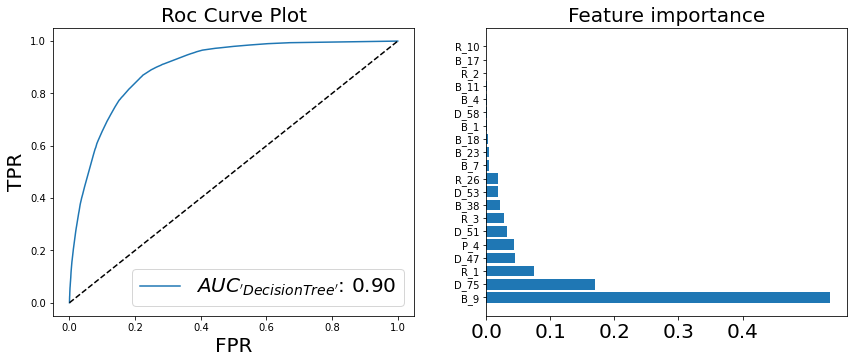

In [34]:
fig = plt.figure(figsize=(22, 18)) 
fig_dims = (3, 3)

y_pred_dt = dtc.predict(X_test_SKB)
y_score_dt = dtc.predict_proba(X_test_SKB)
fpr, tpr, _ = roc_curve(y_test, y_score_dt[:, 1])
roc_auc = auc(fpr, tpr)

print(f"ROC AUC {roc_auc}")
print(f"Accuracy {accuracy_score(y_test, y_pred_dt)}")
print(f"F1-score {f1_score(y_test, y_pred_dt, average=None)}")
print(classification_report(y_test, y_pred_dt))

plt.subplot2grid(fig_dims, (0, 0))
plt.plot(fpr, tpr, label=f"$AUC_{{'DecisionTree'}}$: {roc_auc:.2f}", color = 'C0')
plt.plot([0,1], [0,1], 'k--')
plt.title('Roc Curve Plot', fontsize=20)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.legend(fontsize=20)

plt.subplot2grid(fig_dims, (0, 1))
imp_dict = {attr: dtc.feature_importances_[i] for i, attr in enumerate(selected_features)} #measuring feature importance
importances = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1], reverse=True)} #so that they are sorted
feat_list = [i for i in importances.keys()]
plt.barh(feat_list, importances.values())
plt.xticks(np.arange(0, 0.42, 0.1), fontsize=20)
plt.yticks(fontsize=10)
plt.title("Feature importance", fontsize=20)

plt.show()



### Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=20,
                             min_weight_fraction_leaf=0, random_state=42)

rfc.fit(X_train_SKB, np.ravel(y_train))

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=20,
                       min_weight_fraction_leaf=0, random_state=42)

ROC AUC 0.9174918280040363
Accuracy 0.8558007520609362
F1-score [0.90501161 0.70078652]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91    124536
           1       0.73      0.68      0.70     41408

    accuracy                           0.86    165944
   macro avg       0.81      0.80      0.80    165944
weighted avg       0.85      0.86      0.85    165944



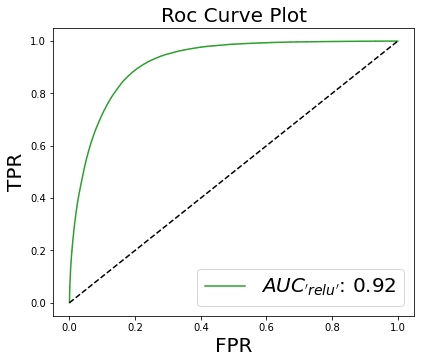

In [36]:
fig = plt.figure(figsize=(22, 18)) 
fig_dims = (3, 3)

y_pred_rfc = rfc.predict(X_test_SKB)
y_score_rfc = rfc.predict_proba(X_test_SKB)
fpr, tpr, _ = roc_curve(y_test, y_score_rfc[:, 1])
roc_auc = auc(fpr, tpr)

print(f"ROC AUC {roc_auc}")
print(f"Accuracy {accuracy_score(y_test, y_pred_rfc)}")
print(f"F1-score {f1_score(y_test, y_pred_rfc, average=None)}")
print(classification_report(y_test, y_pred_rfc))

plt.subplot2grid(fig_dims, (0, 0))
plt.plot(fpr, tpr, label=f"$AUC_{{'relu'}}$: {roc_auc:.2f}", color = 'C2')
plt.plot([0,1], [0,1], 'k--')
plt.title('Roc Curve Plot', fontsize=20)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.legend(fontsize=20)
plt.show()


### Multi-layer Perceptron

In [37]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100, 200), 
                    learning_rate='constant', max_iter=20, 
                    random_state=42, verbose=1)

mlp.fit(X_train_SKB, np.ravel(y_train))

Iteration 1, loss = 0.38699125
Iteration 2, loss = 0.33684241
Iteration 3, loss = 0.33154914
Iteration 4, loss = 0.32637634
Iteration 5, loss = 0.32448205
Iteration 6, loss = 0.32274564
Iteration 7, loss = 0.32213742
Iteration 8, loss = 0.32137308
Iteration 9, loss = 0.32053904
Iteration 10, loss = 0.32005767
Iteration 11, loss = 0.31927868
Iteration 12, loss = 0.31887109
Iteration 13, loss = 0.31841138
Iteration 14, loss = 0.31793291
Iteration 15, loss = 0.31727920
Iteration 16, loss = 0.31699481
Iteration 17, loss = 0.31667647
Iteration 18, loss = 0.31638622
Iteration 19, loss = 0.31605976
Iteration 20, loss = 0.31567606


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(hidden_layer_sizes=(100, 200), max_iter=20, random_state=42,
              verbose=1)

ROC AUC 0.9136171736487386
Accuracy 0.8524080412669334
F1-score [0.9020273  0.70095238]
              precision    recall  f1-score   support

           0       0.90      0.91      0.90    124536
           1       0.71      0.69      0.70     41408

    accuracy                           0.85    165944
   macro avg       0.80      0.80      0.80    165944
weighted avg       0.85      0.85      0.85    165944



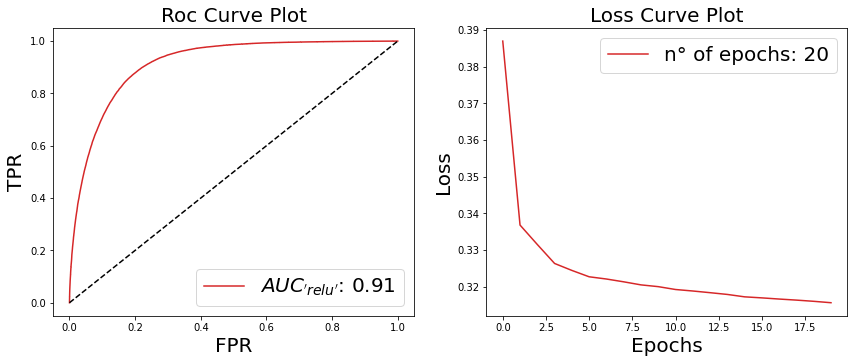

In [38]:
fig = plt.figure(figsize=(22, 18)) 
fig_dims = (3, 3)

y_pred_mlp = mlp.predict(X_test_SKB)
y_score_mlp = mlp.predict_proba(X_test_SKB)
fpr, tpr, _ = roc_curve(y_test, y_score_mlp[:, 1])
roc_auc = auc(fpr, tpr)

print(f"ROC AUC {roc_auc}")
print(f"Accuracy {accuracy_score(y_test, y_pred_mlp)}")
print(f"F1-score {f1_score(y_test, y_pred_mlp, average=None)}")
print(classification_report(y_test, y_pred_mlp))

plt.subplot2grid(fig_dims, (0, 0))
plt.plot(fpr, tpr, label=f"$AUC_{{'relu'}}$: {roc_auc:.2f}", color = 'C3')
plt.plot([0,1], [0,1], 'k--')
plt.title('Roc Curve Plot', fontsize=20)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.legend(fontsize=20)

plt.subplot2grid(fig_dims, (0, 1))
plt.plot(mlp.loss_curve_, label= f'n° of epochs: {len(mlp.loss_curve_)}', color = 'C3')
plt.title('Loss Curve Plot', fontsize=20)
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.legend(fontsize=20)
plt.show()


## Aggregating Predictions on Customers
I will use the RandomForest predictions as they gave me the best results

In [39]:
measure_results = df[['customer_ID', 'target']]
measure_results.index = df['original_indexes'].values
measure_results = measure_results.loc[test_index]

In [40]:
measure_results['prediction_0'] = y_score_rfc[:,0]
measure_results['prediction_1'] = y_score_rfc[:,1]

In [41]:
compare = measure_results.groupby('customer_ID').agg(np.mean)
compare.head()

,target,prediction_0,prediction_1
customer_ID,,,
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.0,0.993493,0.006507
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.0,0.913402,0.086598
00031e8be98bc3411f6037cbd4d3eeaf24b3ae221682b77900533c9bb36ec41f,0.0,0.961954,0.038046
0003b7891c49786441d138c01f55f1712df645989dcd2a83106ab4a229fee72d,0.0,0.960669,0.039331
0003e58375faf90552b2861c1ccea4ee5757827cbb6ecd15a334e47e95774185,0.0,0.964112,0.035888


ROC AUC 0.9180759362178279
Accuracy 0.8562710798605156
F1-score [0.90513159 0.70363058]
              precision    recall  f1-score   support

         0.0       0.89      0.92      0.91    104789
         1.0       0.73      0.68      0.70     35155

    accuracy                           0.86    139944
   macro avg       0.81      0.80      0.80    139944
weighted avg       0.85      0.86      0.85    139944



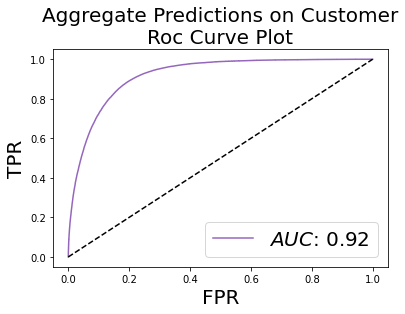

In [42]:
y_test_agg = compare['target'].values
y_score_0 = compare['prediction_0'].values.reshape(-1, 1)
y_score_1 = compare['prediction_1'].values.reshape(-1, 1)

y_pred_agg = [1 if x >= 0.5 else 0 for x in y_score_1]
y_score_agg = np.hstack((y_score_0, y_score_1))

fpr, tpr, _ = roc_curve(y_test_agg, y_score_1)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC {roc_auc}")
print(f"Accuracy {accuracy_score(y_test_agg, y_pred_agg)}")
print(f"F1-score {f1_score(y_test_agg, y_pred_agg, average=None)}")
print(classification_report(y_test_agg, y_pred_agg))

plt.plot(fpr, tpr, label=f"$AUC$: {roc_auc:.2f}", color = 'C4')
plt.plot([0,1], [0,1], 'k--')
plt.title('Aggregate Predictions on Customer\nRoc Curve Plot', fontsize=20)
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.legend(fontsize=20)
plt.show()

# Test set Predict

## Getting the test set

In [43]:
# seeing the datatypes of the features I have
print(df[selected_features].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 553145 entries, 0 to 553144
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   B_1     553145 non-null  float16
 1   R_1     553145 non-null  float16
 2   B_4     553145 non-null  float16
 3   R_2     553145 non-null  float16
 4   D_47    553145 non-null  float16
 5   B_7     553145 non-null  float16
 6   D_51    553145 non-null  float16
 7   B_9     553145 non-null  float16
 8   R_3     553145 non-null  float16
 9   D_53    553145 non-null  float16
 10  B_11    553145 non-null  float16
 11  D_58    553145 non-null  float16
 12  B_17    553145 non-null  float16
 13  B_18    553145 non-null  float16
 14  B_23    553145 non-null  float16
 15  P_4     553145 non-null  float16
 16  D_75    553145 non-null  float16
 17  R_10    553145 non-null  float16
 18  R_26    553145 non-null  float16
 19  B_38    553145 non-null  float16
dtypes: float16(20)
memory usage: 21.1 MB
None


In [44]:
# the trained classifier I will use
rfc

RandomForestClassifier(criterion='entropy', max_depth=14, min_samples_split=20,
                       min_weight_fraction_leaf=0, random_state=42)

In [45]:
# Loading file with the download urls
with open('drive/MyDrive/testset_url.txt', 'r') as f:
    test_url = f.read()

# Downloading and unzipping test data
download_unzip('test', 'training_labels.zip', test_url)

...training_labels.zip downloaded successfully...


Unzipping test_data.csv: 100%|##########| 33824849921/33824849921 [08:55<00:00, 63124157.93it/s]


## Getting the predictions

In [46]:
dataset_size = 11451000 # didn't measure it, just provided the Kaggle rounded n° of records

# Chunking to 100.000 records per iteration
chunksize = 100000
iterations = roundup(dataset_size / chunksize)

cast_as = {attr : np.float16 for attr in selected_features} # as seen before
cast_as.update({'customer_ID' : str})

df_iter = pd.read_csv('test/test_data.csv', usecols = ['customer_ID'] + selected_features, 
                      dtype = cast_as, chunksize=chunksize)

customers = list() # where I will store the customer_ID
predictions = list() # where I will store the predictions

for n, df_chunk in tqdm(enumerate(df_iter), total = iterations):
    customers += df_chunk['customer_ID'].values.tolist()
    df_chunk.drop('customer_ID', axis = 1, inplace = True)
    X_test_real = df_chunk.fillna(-99).values
    y_score_real = rfc.predict_proba(X_test_real)[:,1].tolist()
    predictions += y_score_real
    del df_chunk, X_test_real, y_score_real

 99%|█████████▉| 114/115 [09:49<00:05,  5.17s/it]


In [47]:
len(customers) == len(predictions)

True

# Getting the submission file

In [48]:
finilize = pd.DataFrame(zip(customers, predictions), columns = ['customer_ID', 'prediction']).groupby('customer_ID').agg(np.mean)

The submission requires probabilities, not a binary classification

In [49]:
#prediction_round = [1 if x >= 0.5 else 0 for x in finilize['prediction']]
finilize.reset_index(inplace = True)
#finilize['prediction'] = prediction_round

In [50]:
finilize.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.177942
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.009357
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.068740
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.660639
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.769679


In [51]:
finilize.to_csv('drive/MyDrive/submission.csv', index = False)

# Next things to do:

*   Making some serious feature selection
*   Keeping into account the past actions of each customer
*   Decide how to handle missing values (I don't know yet if -99 is the best I can do)
*   Making hyperparameter tuning on some samples